# Chronos Fine-tuning and Evaluation for INTC Stock Data (1H Timeframe)

This notebook provides a workflow for:
1. Fine-tuning the Chronos model on INTC 1H data.
2. Performing a robust rolling window evaluation of the fine-tuned model.
3. Comparing the fine-tuned model's performance against a zero-shot Chronos model on the 1H timeframe.

## Key Improvements and Focus:
- **Error Resolution**: Addresses potential mismatches in prediction and actual value lengths during evaluation.
- **1H Timeframe Focus**: All analysis, fine-tuning, and evaluation are concentrated on the 1-hour interval data for INTC.
- **Comprehensive Metrics**: Evaluation includes MAE, RMSE, and MAPE.
- **Enhanced Readability**: Improved markdown and code comments for better understanding.
- **Standardized Evaluation**: Consistent output structure for both fine-tuned and zero-shot model evaluations.

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from chronos import ChronosBoltPipeline
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# --- Configuration Constants ---
MODEL_NAME = "amazon/chronos-bolt-base"  # Original Chronos model
CONTEXT_LENGTH = 512  # Fixed context length for Chronos Bolt
PREDICTION_LENGTH = 128  # Forecast horizon
TICKER = "INTC"
# Focus solely on 1H timeframe
PRIMARY_TIMEFRAME = "1H"
TIMEFRAMES = [PRIMARY_TIMEFRAME] 

# --- Directory Setup ---
results_dir = os.path.join(os.getcwd(), '..', 'results')
base_data_dir = os.path.join(os.getcwd(), '..', 'data')
# Ensure the main directory for this notebook's results exists
comprehensive_results_dir = os.path.join(results_dir, 'comprehensive_1H_analysis')
os.makedirs(comprehensive_results_dir, exist_ok=True)

print(f"Configuration:")
print(f"  Ticker: {TICKER}")
print(f"  Timeframe for Analysis: {PRIMARY_TIMEFRAME}")
print(f"  Base Model: {MODEL_NAME}")
print(f"  Context Length: {CONTEXT_LENGTH}")
print(f"  Prediction Length: {PREDICTION_LENGTH}")
print(f"  Results will be saved in: {comprehensive_results_dir}")

# --- Metric Calculation Functions ---
def calculate_mape(y_true, y_pred):
    """Calculates Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero: filter out true values that are zero or very close to zero
    mask = np.abs(y_true) > 1e-8 # Use a small epsilon to avoid division by zero for near-zero actuals
    if not np.any(mask): # All true values are zero or near-zero
        # MAPE is undefined if any pred is non-zero, or 0 if all preds are also zero (or near-zero).
        return np.nan if np.any(np.abs(y_pred) > 1e-8) else 0.0
    
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    if len(y_true_filtered) == 0: # Should be caught by np.any(mask) but as a safeguard
        return np.nan

    return np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100

# --- Plotting Function ---
def plot_forecast(dates, actual_values, forecast_values, title, save_path=None, figsize=(18, 6)):
    """Plots actual vs. forecast values and displays MAE, RMSE, MAPE in the title."""
    plt.figure(figsize=figsize)
    
    plt.plot(dates, actual_values, color='green', label='Actual')
    plt.plot(dates, forecast_values, color='red', linestyle='--', marker='o', markersize=3, label='Predicted')
    
    # Calculate metrics for the plot title
    mae = mean_absolute_error(actual_values, forecast_values)
    rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
    mape = calculate_mape(actual_values, forecast_values)
    
    plt.title(f"{title}\n(MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%)", fontsize=14)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price ($)', fontsize=10)
    plt.xticks(rotation=45)
    plt.legend(frameon=True, shadow=True)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()
    
    return mae, rmse, mape # Return all three metrics

Configuration:
  Ticker: INTC
  Timeframe for Analysis: 1H
  Base Model: amazon/chronos-bolt-base
  Context Length: 512
  Prediction Length: 128
  Results will be saved in: c:\Users\micha\code\finance\diploma\notebooks\..\results\comprehensive_1H_analysis


Loaded INTC 1H: 8306 rows
Data for 1H timeframe:
  Total preprocessed rows: 7808
  Training data rows: 6246
  Test data rows: 1562
Data for 1H timeframe:
  Total preprocessed rows: 7808
  Training data rows: 6246
  Test data rows: 1562


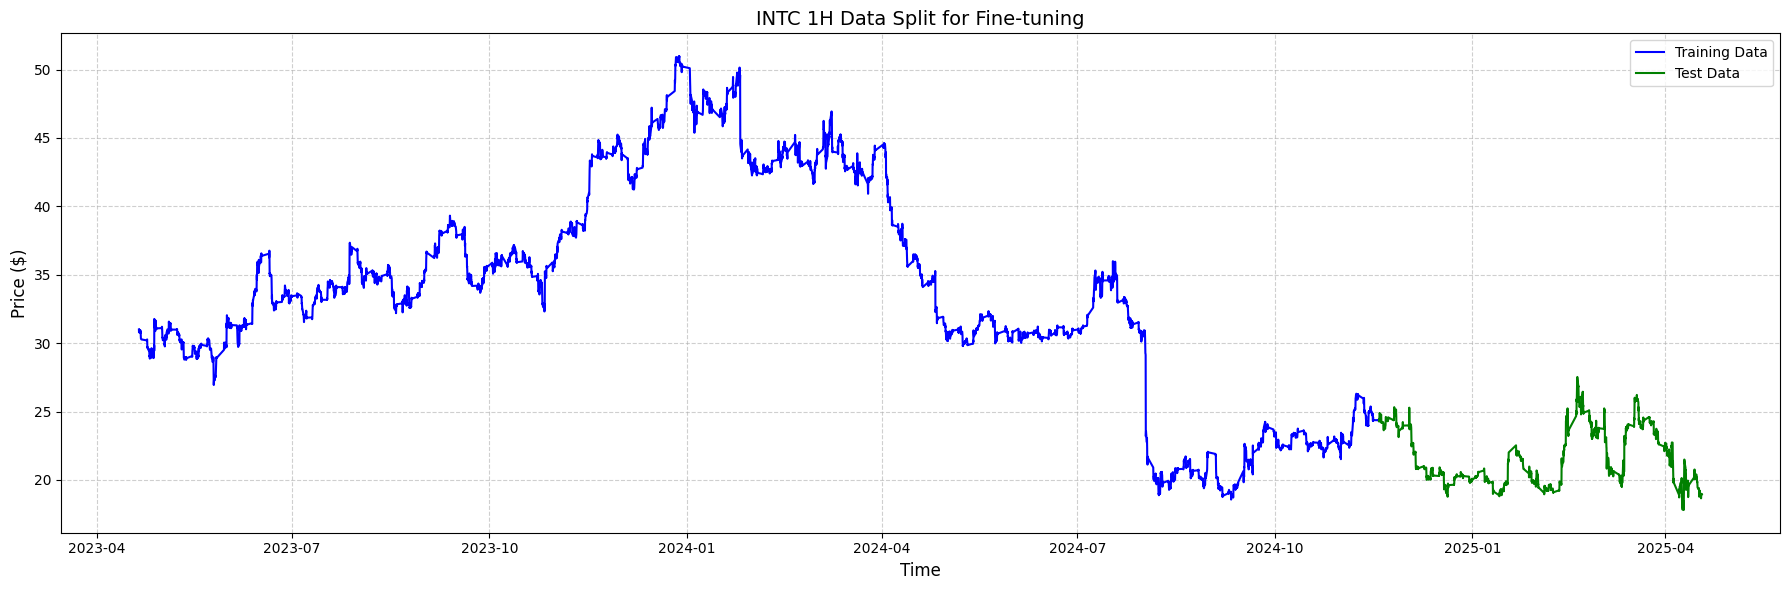

In [18]:
# Helper functions for data loading and preprocessing
def load_stock_data(ticker, timeframe_to_load):
    """Load data for the specified ticker and timeframe."""
    stock_data_loaded = {}
    file_path = os.path.join(base_data_dir, timeframe_to_load, f'{ticker}_{timeframe_to_load}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)
        df['Datetime'] = df['Datetime'].dt.tz_localize(None)
        stock_data_loaded[timeframe_to_load] = df
        print(f"Loaded {ticker} {timeframe_to_load}: {df.shape[0]} rows")
    else:
        print(f"ERROR: Data file not found for {ticker} {timeframe_to_load} at {file_path}")
    return stock_data_loaded

def prepare_chronos_data(df, item_id_str, freq_str):
    """Prepare data for Chronos model using TimeSeriesDataFrame."""
    chronos_df_prep = pd.DataFrame({
        'item_id': item_id_str,
        'timestamp': df['Datetime'],
        'target': df['Close']
    })
    chronos_tsd_prep = TimeSeriesDataFrame.from_data_frame(
        chronos_df_prep, id_column='item_id', timestamp_column='timestamp'
    )
    # Convert to regular frequency and drop NaNs from resampling
    chronos_tsd_prep = chronos_tsd_prep.convert_frequency(freq=freq_str)
    chronos_tsd_prep = chronos_tsd_prep.dropna()
    return chronos_tsd_prep

# Load data for the primary timeframe
stock_data = load_stock_data(TICKER, PRIMARY_TIMEFRAME)

# Prepare data for the primary timeframe (for fine-tuning and evaluation)
chronos_train = None
chronos_test = None
chronos_tsd = None

if PRIMARY_TIMEFRAME in stock_data:
    chronos_tsd = prepare_chronos_data(stock_data[PRIMARY_TIMEFRAME], TICKER, PRIMARY_TIMEFRAME)
    
    if chronos_tsd is not None and not chronos_tsd.empty:
        # Split into train and test sets (80/20 split)
        split_idx = int(len(chronos_tsd) * 0.8)
        chronos_train = chronos_tsd.iloc[:split_idx]
        chronos_test = chronos_tsd.iloc[split_idx:]
        
        print(f"Data for {PRIMARY_TIMEFRAME} timeframe:")
        print(f"  Total preprocessed rows: {len(chronos_tsd)}")
        print(f"  Training data rows: {len(chronos_train)}")
        print(f"  Test data rows: {len(chronos_test)}")
        
        # Plot the training and test data split
        plt.figure(figsize=(18, 6))
        plt.plot(chronos_train.index.get_level_values('timestamp'), chronos_train['target'], 
                 label='Training Data', color='blue')
        plt.plot(chronos_test.index.get_level_values('timestamp'), chronos_test['target'], 
                 label='Test Data', color='green')
        plt.title(f'{TICKER} {PRIMARY_TIMEFRAME} Data Split for Fine-tuning', fontsize=14)
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('Price ($)', fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Error: Preprocessed data for {PRIMARY_TIMEFRAME} is empty or None.")
elif not stock_data:
    print(f"ERROR: No data loaded for {TICKER}. Please check data paths and file existence.")
else:
    print(f"ERROR: {PRIMARY_TIMEFRAME} data not found for {TICKER}. Cannot proceed.")

## 1. Data Loading and Preprocessing

This section loads the INTC 1H stock data, prepares it in the format required by AutoGluon TimeSeries, and splits it into training and testing sets.

In [19]:
# Fine-tune the Chronos model on the primary timeframe
print(f"Fine-tuning Chronos model on {TICKER} {PRIMARY_TIMEFRAME} data...")
print(f"Using base model: {MODEL_NAME}")

# Create a directory for the model
save_path = f'autogluon-chronos-{TICKER}-{PRIMARY_TIMEFRAME}'
os.makedirs(save_path, exist_ok=True)

# Format the model name correctly for later reference
model_name_formatted = f"Chronos[{MODEL_NAME.replace('/', '__')}]"
print(f"Formatted model name for reference: {model_name_formatted}")

try:
    chronos_predictor = TimeSeriesPredictor(
        target='target',
        prediction_length=PREDICTION_LENGTH,
        path=save_path,
        eval_metric='MASE',
        freq=PRIMARY_TIMEFRAME,
    )

    chronos_predictor.fit(
        chronos_train,
        hyperparameters={'Chronos': {"model_path": MODEL_NAME}},
        presets='medium_quality',
        time_limit=600,  # 10 minutes time limit
    )
    print("Fine-tuning complete!")
except Exception as e:
    print(f"Error during fine-tuning: {str(e)}")
    print("Check model configuration and data format.")

Frequency '1H' stored as 'h'
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'c:\Users\micha\code\finance\diploma\notebooks\autogluon-chronos-INTC-1H'
Frequency '1H' stored as 'h'
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'c:\Users\micha\code\finance\diploma\notebooks\autogluon-chronos-INTC-1H'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.10.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
GPU Count:          0
Memory Avail:       31.85 GB / 63.10 GB (50.5%)
Disk Space Avail:   171.18 GB / 465.02 GB (36.8%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': {'Chronos': {'model_path': 'amazon/chronos-bolt-base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 128,
 'quantile_levels': [

Fine-tuning Chronos model on INTC 1H data...
Using base model: amazon/chronos-bolt-base
Formatted model name for reference: Chronos[amazon__chronos-bolt-base]


Provided train_data has 13869 rows (NaN fraction=55.0%), 1 time series. Median time series length is 13869 (min=13869, max=13869). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-05-13 19:12:18
Models that will be trained: ['Chronos[amazon__chronos-bolt-base]']

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-05-13 19:12:18
Models that will be trained: ['Chronos[amazon__chronos-bolt-base]']
Training timeseries model Chronos[amazon__chronos-bolt-base]. Traini

Fine-tuning complete!


## 2. Model Fine-tuning

This section fine-tunes the Chronos model using AutoGluon TimeSeriesPredictor on the prepared 1H training data.

In [20]:
# Unified function for rolling window evaluation
def evaluate_with_rolling_windows(predictor_obj, test_data_tsdf, model_identifier_str, eval_type_str, current_ticker_str, current_tf_str):
    """
    Evaluate a model (fine-tuned or zero-shot) using a rolling window approach.
    Returns lists of aggregated dates, actual values, and predicted values across all windows.

    Parameters:
    - predictor_obj: AutoGluon TimeSeriesPredictor (for fine-tuned) or ChronosBoltPipeline (for zero-shot).
    - test_data_tsdf: TimeSeriesDataFrame with test data.
    - model_identifier_str: Name of the specific model (for fine-tuned) or a descriptive name (for zero-shot).
    - eval_type_str: Type of evaluation - "finetuned" or "zeroshot".
    - current_ticker_str: The ticker symbol (e.g., "INTC").
    - current_tf_str: The timeframe string (e.g., "1H").
    """
    print(f"\nStarting rolling window evaluation for {eval_type_str} model ({model_identifier_str}) on {current_tf_str}...")
    
    ts_id = test_data_tsdf.index.get_level_values('item_id')[0]
    values_np = test_data_tsdf.loc[ts_id]['target'].values
    timestamps_np = test_data_tsdf.loc[ts_id].index.values
    
    # Calculate how many windows we can create
    max_start = len(values_np) - CONTEXT_LENGTH - PREDICTION_LENGTH
    if max_start < 0:
        print(f"  Warning: Test dataset for {current_tf_str} too small for forecasting (context={CONTEXT_LENGTH}, prediction={PREDICTION_LENGTH}). Skipping evaluation.")
        return [], [], []
    
    window_starts = list(range(0, max_start + 1, PREDICTION_LENGTH)) # Stride by PREDICTION_LENGTH for non-overlapping forecast windows
    if not window_starts and max_start >=0: # Ensure at least one window if possible
        window_starts = [0]
    
    if not window_starts:
        print(f"  Warning: No evaluation windows for {current_tf_str}. Dataset size: {len(values_np)}. Skipping.")
        return [], [], []
        
    print(f"  Evaluating {len(window_starts)} rolling windows for {current_tf_str}.")
    
    all_actuals_list, all_preds_list, all_dates_list = [], [], []
    
    # Create directory for this evaluation type's window results
    window_results_basedir = os.path.join(comprehensive_results_dir, f'{eval_type_str}_{current_tf_str}_{current_ticker_str}')
    os.makedirs(window_results_basedir, exist_ok=True)
    
    for i, start_idx in enumerate(window_starts):
        print(f"    Processing window {i+1}/{len(window_starts)} for {current_tf_str}...")
        
        context_end_idx = start_idx + CONTEXT_LENGTH
        prediction_actual_end_idx = min(context_end_idx + PREDICTION_LENGTH, len(values_np))

        if context_end_idx > len(values_np) or prediction_actual_end_idx <= context_end_idx:
            print(f"      Skipping window {i+1}: Not enough data for full context or any prediction.")
            continue
            
        # Prepare context data for prediction
        context_data_for_pred = test_data_tsdf.iloc[start_idx:context_end_idx]
        
        try:
            actual_window_vals = values_np[context_end_idx:prediction_actual_end_idx]
            dates_window_vals = timestamps_np[context_end_idx:prediction_actual_end_idx]
            pred_window_vals_mean = []

            if eval_type_str == "finetuned":
                if predictor_obj is None:
                    print(f"      Skipping window {i+1}: Fine-tuned predictor is None.")
                    continue
                predictions_df = predictor_obj.predict(context_data_for_pred, model=model_identifier_str)
                if 'mean' in predictions_df.columns and ts_id in predictions_df.index:
                    pred_window_vals_mean = predictions_df.loc[ts_id]['mean'].values
                else:
                    print(f"      Error in window {i+1} (fine-tuned): 'mean' column or item_id '{ts_id}' not in predictions. Columns: {predictions_df.columns}, Index: {predictions_df.index}. Skipping.")
                    continue
            
            elif eval_type_str == "zeroshot":
                context_tensor = torch.tensor(context_data_for_pred['target'].values, dtype=torch.float32)
                if len(context_tensor) < CONTEXT_LENGTH:
                    print(f"      Skipping window {i+1} (zero-shot): Context tensor length {len(context_tensor)} is less than CONTEXT_LENGTH {CONTEXT_LENGTH}.")
                    continue
                
                _, mean_forecast_tensor = predictor_obj.predict_quantiles(
                    context=context_tensor.unsqueeze(0), # Add batch dimension
                    prediction_length=PREDICTION_LENGTH,
                    quantile_levels=[0.5] # Only need mean for this evaluation
                )
                pred_window_vals_mean = mean_forecast_tensor.squeeze().cpu().numpy()
            else:
                print(f"      Skipping window {i+1}: Unknown eval_type_str '{eval_type_str}'.")
                continue

            # Align actual and prediction lengths
            len_actual = len(actual_window_vals)
            len_pred = len(pred_window_vals_mean)
            min_len = min(len_actual, len_pred)

            if min_len == 0:
                print(f"      Skipping window {i+1}: No overlapping actuals/predictions after alignment (Actuals: {len_actual}, Preds: {len_pred}).")
                continue
            if len_pred < PREDICTION_LENGTH and len_actual >= PREDICTION_LENGTH:
                 print(f"      Note for window {i+1}: Model returned {len_pred} predictions, expected up to {PREDICTION_LENGTH}. Using {min_len} points for metrics.")

            actual_window_aligned = actual_window_vals[:min_len]
            pred_window_aligned = pred_window_vals_mean[:min_len]
            dates_window_aligned = dates_window_vals[:min_len]

            if not (actual_window_aligned.ndim == 1 and pred_window_aligned.ndim == 1 and len(actual_window_aligned) == len(pred_window_aligned)):
                print(f"      Skipping window {i+1} due to mismatched lengths or dimensions after final alignment attempt.")
                continue
            if len(dates_window_aligned) != len(actual_window_aligned):
                print(f"      Skipping window {i+1} due to mismatched dates and actuals length after final alignment.")
                continue

            all_actuals_list.extend(actual_window_aligned)
            all_preds_list.extend(pred_window_aligned)
            all_dates_list.extend(dates_window_aligned)
            
            # Calculate window metrics
            window_mae = mean_absolute_error(actual_window_aligned, pred_window_aligned)
            window_rmse = np.sqrt(mean_squared_error(actual_window_aligned, pred_window_aligned))
            window_mape = calculate_mape(actual_window_aligned, pred_window_aligned)
            print(f"      Window {i+1} Metrics - MAE: {window_mae:.4f}, RMSE: {window_rmse:.4f}, MAPE: {window_mape:.2f}%")
            
            # Save window results to CSV
            results_df_window = pd.DataFrame({
                'date': dates_window_aligned,
                'actual': actual_window_aligned,
                'forecast': pred_window_aligned
            })
            csv_path_window = os.path.join(window_results_basedir, f'window_{i+1}_results.csv')
            results_df_window.to_csv(csv_path_window, index=False)

            # Plot and save individual window forecast
            plot_title_window = f'{current_ticker_str} {current_tf_str} - {eval_type_str.capitalize()} Window {i+1}/{len(window_starts)}'
            plot_save_path_window = os.path.join(window_results_basedir, f'window_{i+1}_plot.png')
            if len(dates_window_aligned) > 0:
                 plot_forecast(dates_window_aligned, actual_window_aligned, pred_window_aligned, plot_title_window, save_path=plot_save_path_window)
            else:
                print(f"      Skipping plot for window {i+1} as there is no data for plotting after alignment.")
            
        except Exception as e:
            print(f"      ERROR processing window {i+1} for {eval_type_str} model: {str(e)}. Skipping window.")
            import traceback
            traceback.print_exc() # Provides more detailed error information
            continue
    
    if not all_actuals_list:
        print(f"  Warning: No data collected from any window for {eval_type_str} model on {current_tf_str}. Evaluation might have failed for all windows.")

    return all_dates_list, all_actuals_list, all_preds_list

# Fine-tuning Chronos model
model_name_formatted = None
chronos_predictor = None

if chronos_train is not None and not chronos_train.empty:
    print(f"Fine-tuning Chronos model on {TICKER} {PRIMARY_TIMEFRAME} data...")
    print(f"Using base model: {MODEL_NAME}")

    # Define save path for the fine-tuned model within the comprehensive results directory
    ft_model_save_path = os.path.join(comprehensive_results_dir, f'autogluon-chronos-{TICKER}-{PRIMARY_TIMEFRAME}')
    os.makedirs(ft_model_save_path, exist_ok=True) 

    # Format the model name for AutoGluon's internal reference
    model_name_formatted = f"Chronos[{MODEL_NAME.replace('/', '__')}]"
    print(f"Formatted model name for AutoGluon reference: {model_name_formatted}")

    try:
        chronos_predictor = TimeSeriesPredictor(
            target='target',
            prediction_length=PREDICTION_LENGTH,
            path=ft_model_save_path, # Directory to store model artifacts
            eval_metric='MASE', # Evaluation metric for model selection during training
            freq=PRIMARY_TIMEFRAME,
        )

        chronos_predictor.fit(
            chronos_train,
            hyperparameters={'Chronos': {"model_path": MODEL_NAME}}, # Specify Chronos and its base model
            presets='medium_quality', # Balances training time and model quality
            time_limit=600,  # Time limit for training in seconds (e.g., 10 minutes)
        )
        print("Fine-tuning complete!")
    except Exception as e:
        print(f"ERROR during fine-tuning: {str(e)}")
        print("Please check model configuration, data format, and available resources.")
        chronos_predictor = None # Ensure predictor is None if fit fails
else:
    print("Skipping fine-tuning as training data is not available or empty.")

Frequency '1H' stored as 'h'
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'c:\Users\micha\code\finance\diploma\results\comprehensive_1H_analysis\autogluon-chronos-INTC-1H'
Frequency '1H' stored as 'h'
Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'c:\Users\micha\code\finance\diploma\results\comprehensive_1H_analysis\autogluon-chronos-INTC-1H'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.10.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          32
GPU Count:          0
Memory Avail:       32.23 GB / 63.10 GB (51.1%)
Disk Space Avail:   171.18 GB / 465.02 GB (36.8%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': {'Chronos': {'model_path': 'amazon/chronos-bolt-base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,


Fine-tuning Chronos model on INTC 1H data...
Using base model: amazon/chronos-bolt-base
Formatted model name for AutoGluon reference: Chronos[amazon__chronos-bolt-base]


Provided train_data has 13869 rows (NaN fraction=55.0%), 1 time series. Median time series length is 13869 (min=13869, max=13869). 

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-05-13 19:12:19

Provided data contains following columns:
	target: 'target'

AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.

Starting training. Start time is 2025-05-13 19:12:19
Models that will be trained: ['Chronos[amazon__chronos-bolt-base]']
Training timeseries model Chronos[amazon__chronos-bolt-base]. Training for up to 599.8s of the 599.8s of remaining time.
Models that wil

Fine-tuning complete!


## 3. Evaluation Functions

This section defines a unified helper function for performing rolling window evaluations for both the fine-tuned and zero-shot models, including MAPE metric calculation and standardized output saving.

data with frequency 'IRREG' has been resampled to frequency 'h'.


Running fine-tuned model evaluation on 1H test data...

Starting rolling window evaluation for finetuned model (Chronos[amazon__chronos-bolt-base]) on 1H...
  Evaluating 8 rolling windows for 1H.
    Processing window 1/8 for 1H...
      Window 1 Metrics - MAE: 1.0786, RMSE: 1.2183, MAPE: 5.22%
      Window 1 Metrics - MAE: 1.0786, RMSE: 1.2183, MAPE: 5.22%


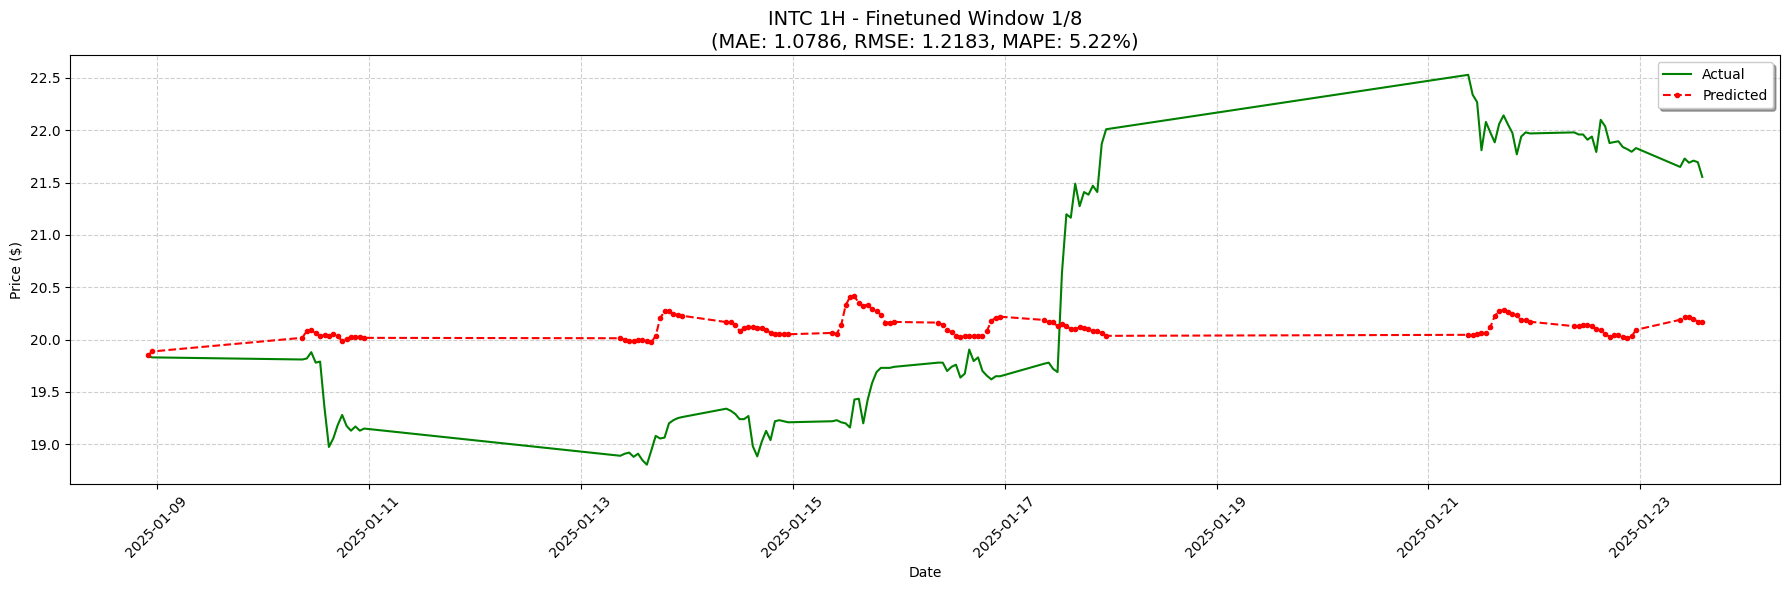

data with frequency 'IRREG' has been resampled to frequency 'h'.


    Processing window 2/8 for 1H...
      Window 2 Metrics - MAE: 1.0285, RMSE: 1.1544, MAPE: 5.21%
      Window 2 Metrics - MAE: 1.0285, RMSE: 1.1544, MAPE: 5.21%


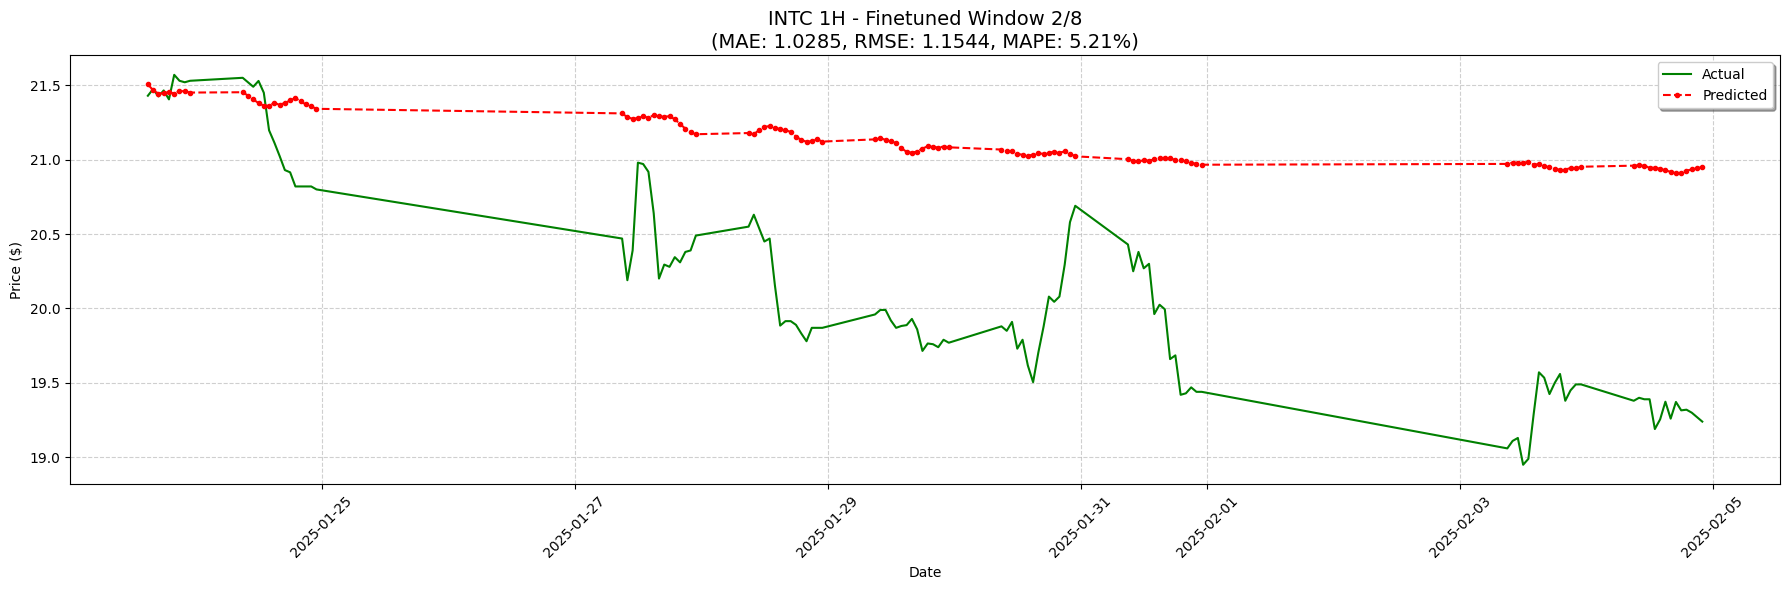

data with frequency 'IRREG' has been resampled to frequency 'h'.


    Processing window 3/8 for 1H...
      Window 3 Metrics - MAE: 1.9501, RMSE: 2.8018, MAPE: 8.40%
      Window 3 Metrics - MAE: 1.9501, RMSE: 2.8018, MAPE: 8.40%


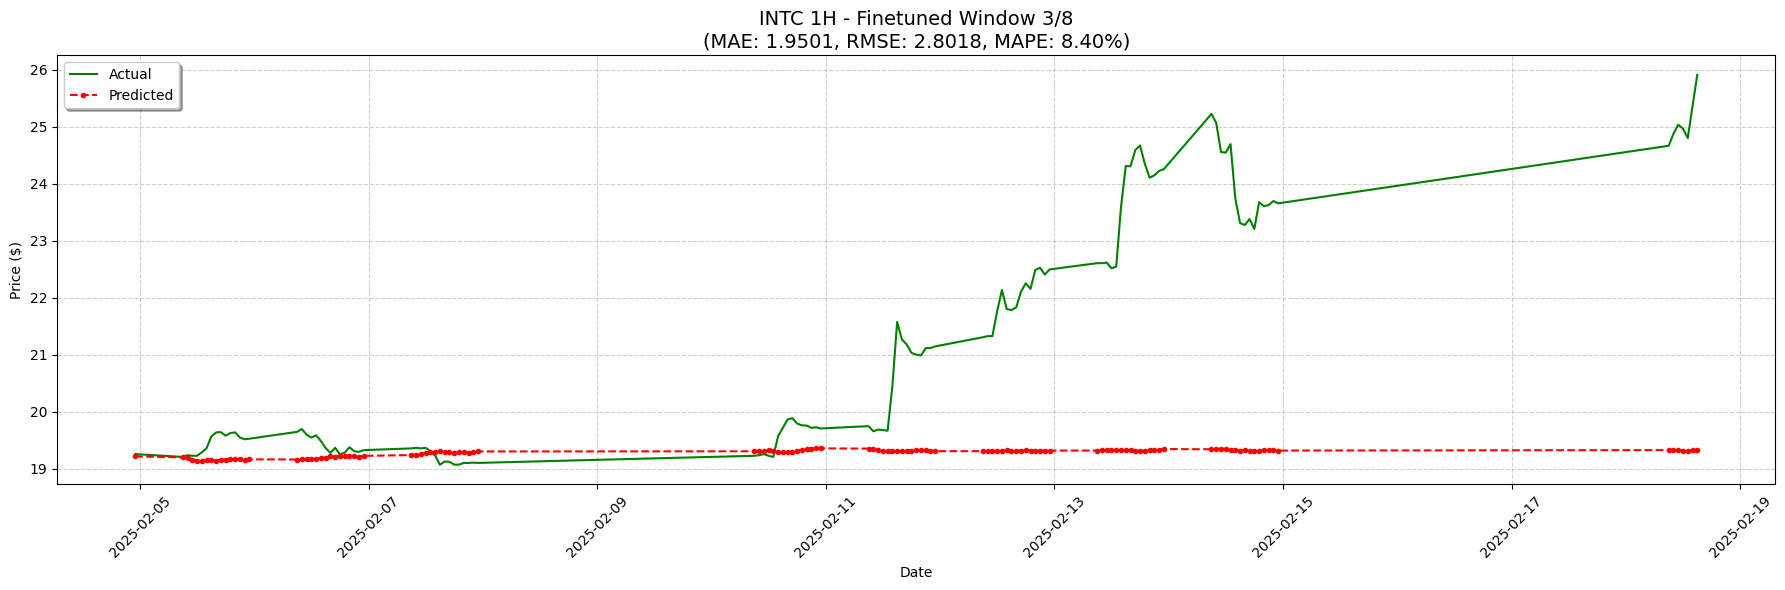

data with frequency 'IRREG' has been resampled to frequency 'h'.


    Processing window 4/8 for 1H...
      Window 4 Metrics - MAE: 1.6617, RMSE: 1.9050, MAPE: 6.93%
      Window 4 Metrics - MAE: 1.6617, RMSE: 1.9050, MAPE: 6.93%


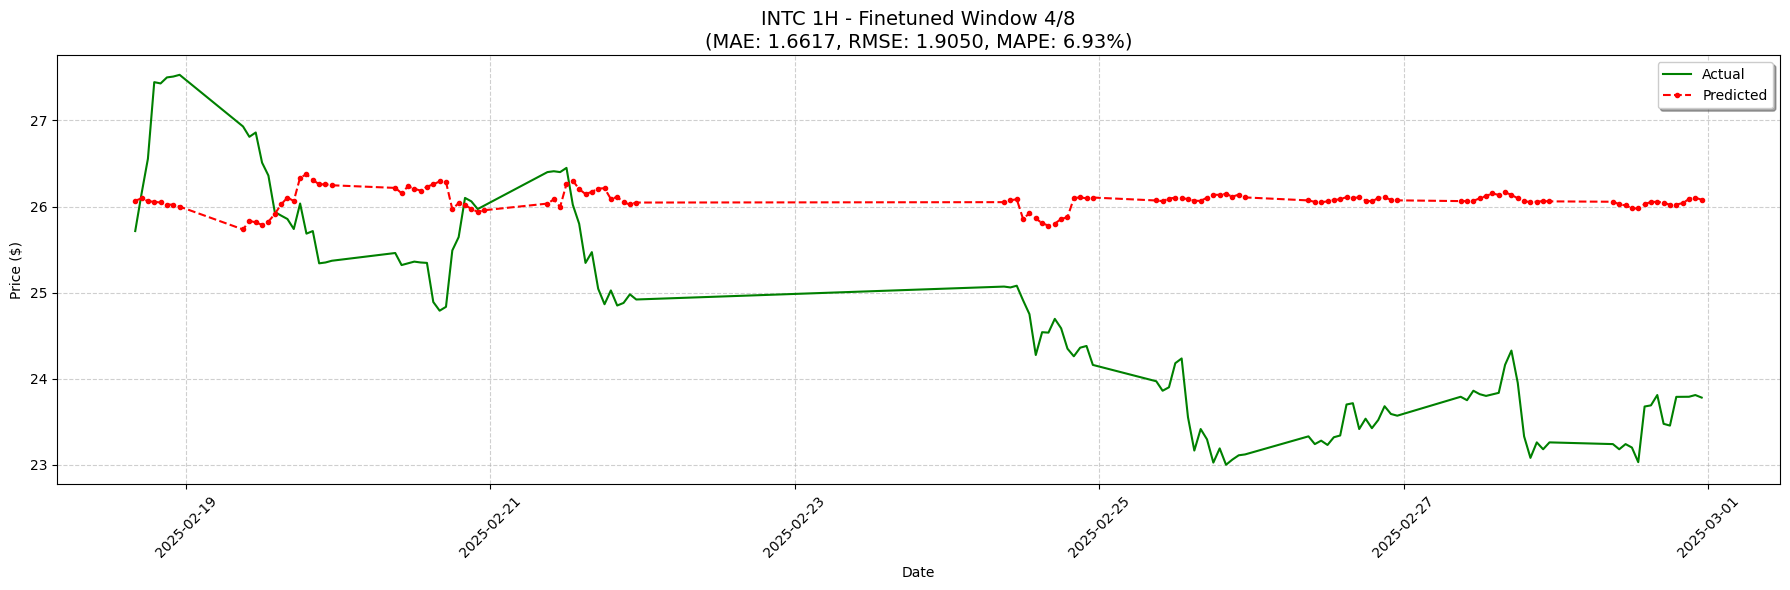

data with frequency 'IRREG' has been resampled to frequency 'h'.


    Processing window 5/8 for 1H...
      Window 5 Metrics - MAE: 2.6135, RMSE: 2.8644, MAPE: 12.64%
      Window 5 Metrics - MAE: 2.6135, RMSE: 2.8644, MAPE: 12.64%


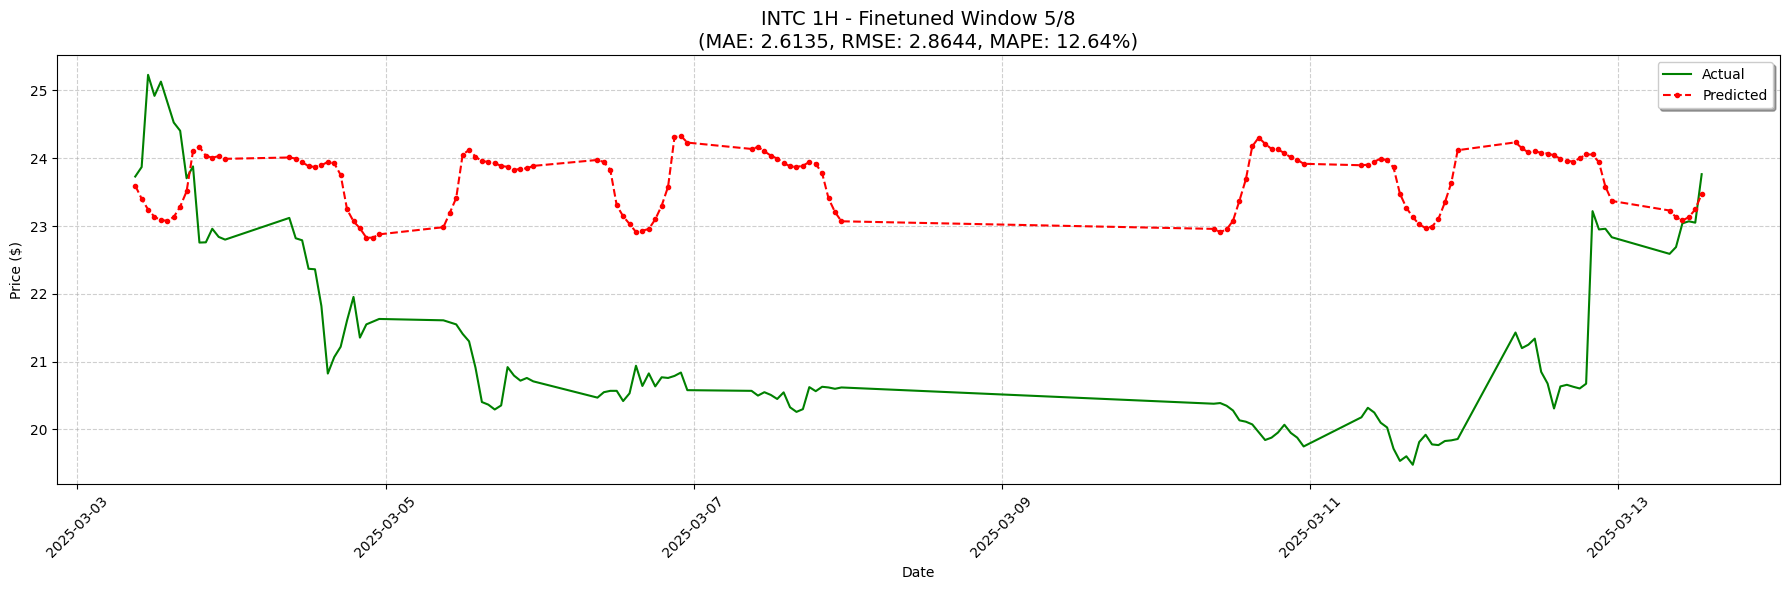

data with frequency 'IRREG' has been resampled to frequency 'h'.


    Processing window 6/8 for 1H...
      Window 6 Metrics - MAE: 1.0913, RMSE: 1.3472, MAPE: 4.39%
      Window 6 Metrics - MAE: 1.0913, RMSE: 1.3472, MAPE: 4.39%


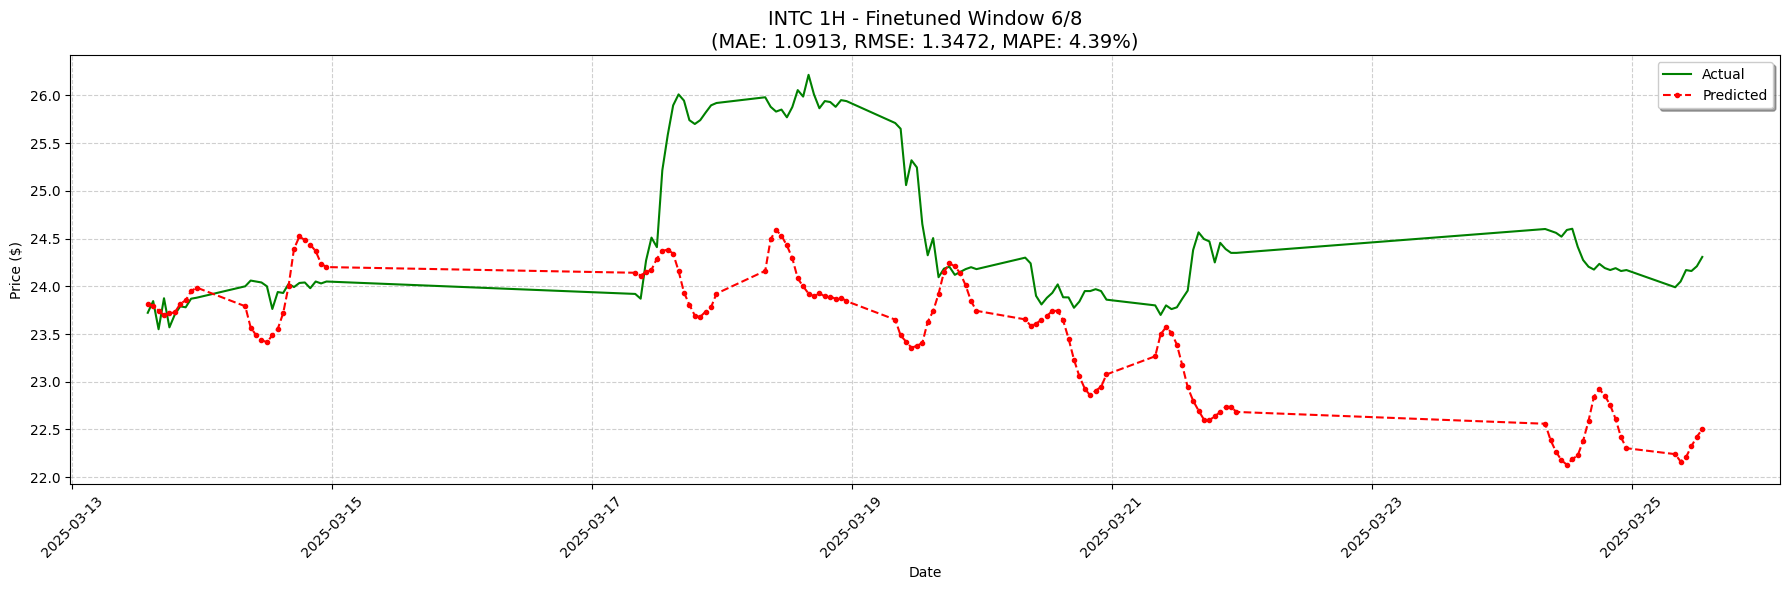

data with frequency 'IRREG' has been resampled to frequency 'h'.


    Processing window 7/8 for 1H...
      Window 7 Metrics - MAE: 1.4778, RMSE: 1.6913, MAPE: 6.66%
      Window 7 Metrics - MAE: 1.4778, RMSE: 1.6913, MAPE: 6.66%


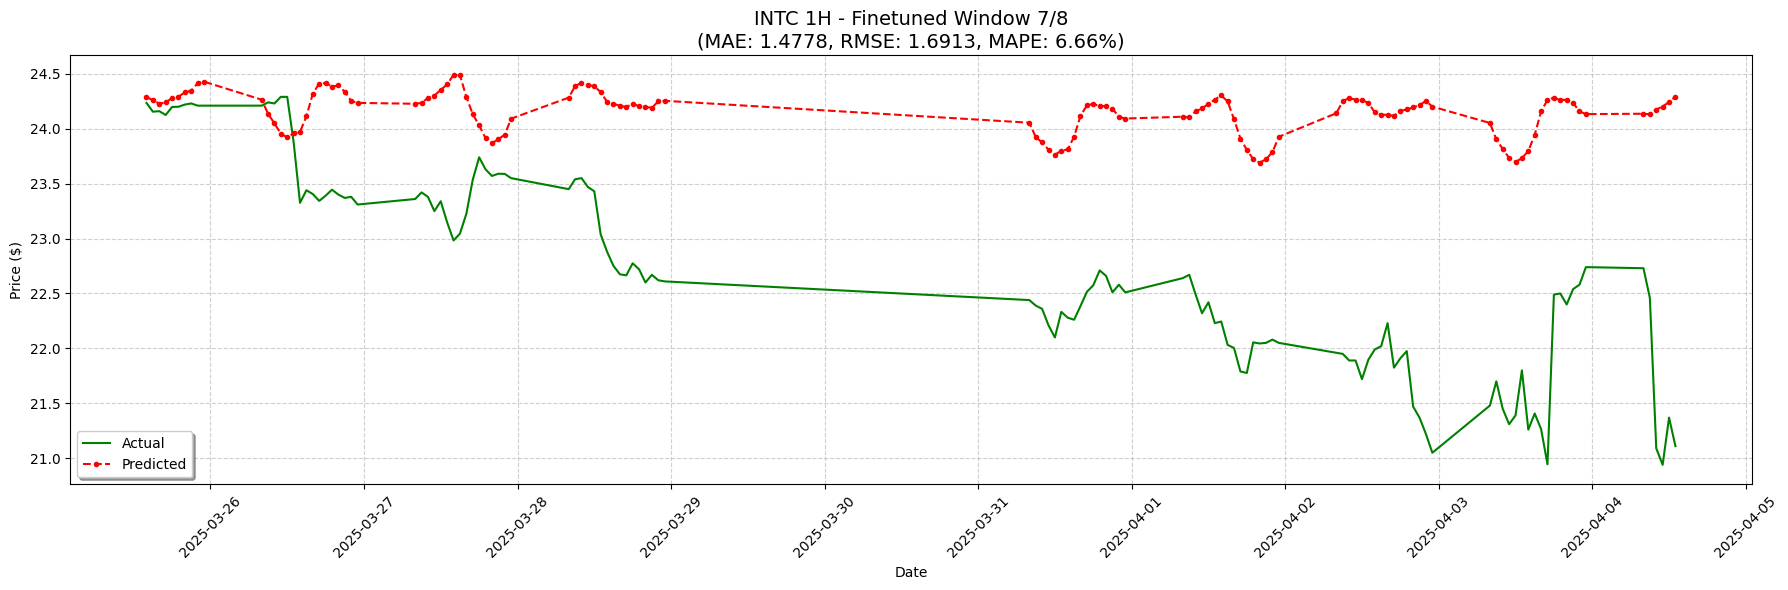

data with frequency 'IRREG' has been resampled to frequency 'h'.


    Processing window 8/8 for 1H...
      Window 8 Metrics - MAE: 1.2974, RMSE: 1.4931, MAPE: 6.73%
      Window 8 Metrics - MAE: 1.2974, RMSE: 1.4931, MAPE: 6.73%


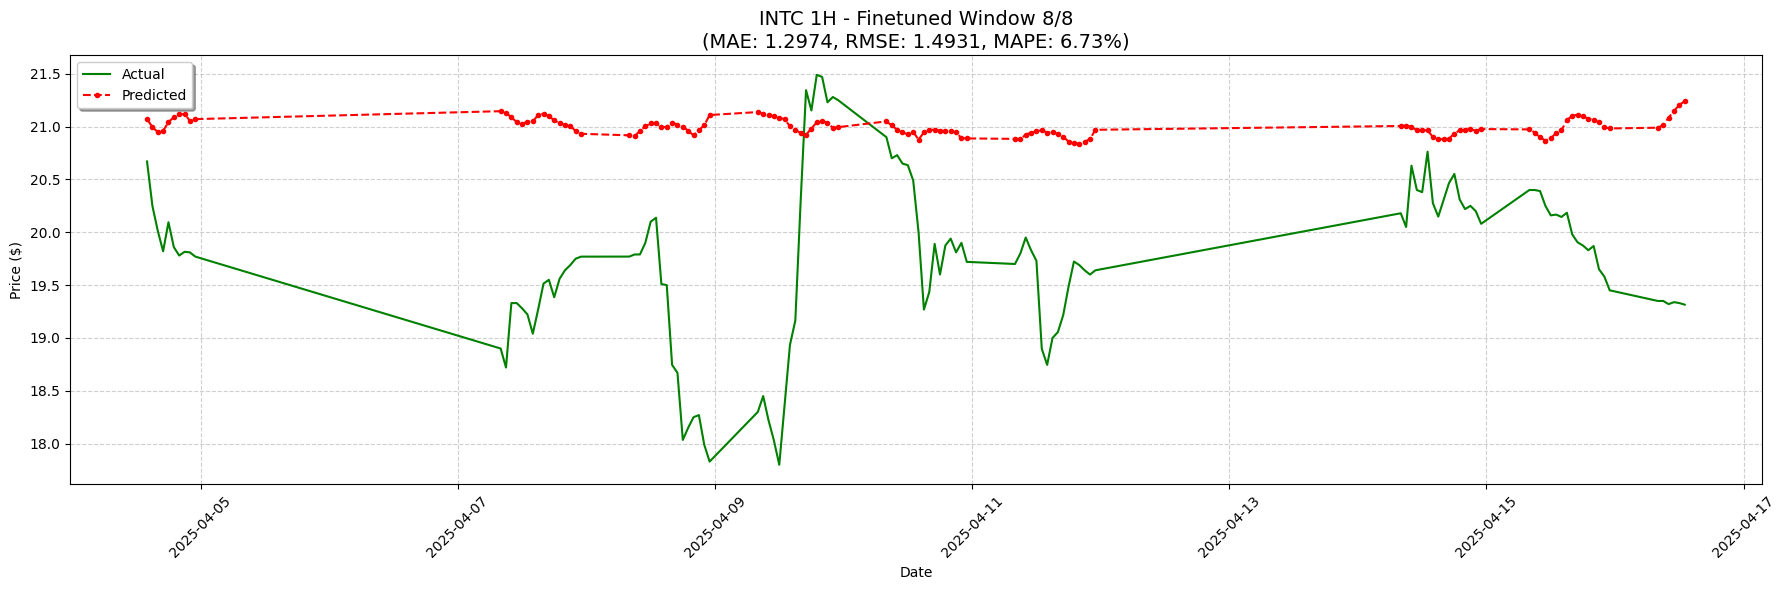


Fine-tuned Model Overall Performance (1H):
  MAE: 1.5249
  RMSE: 1.9172
  MAPE: 7.02%


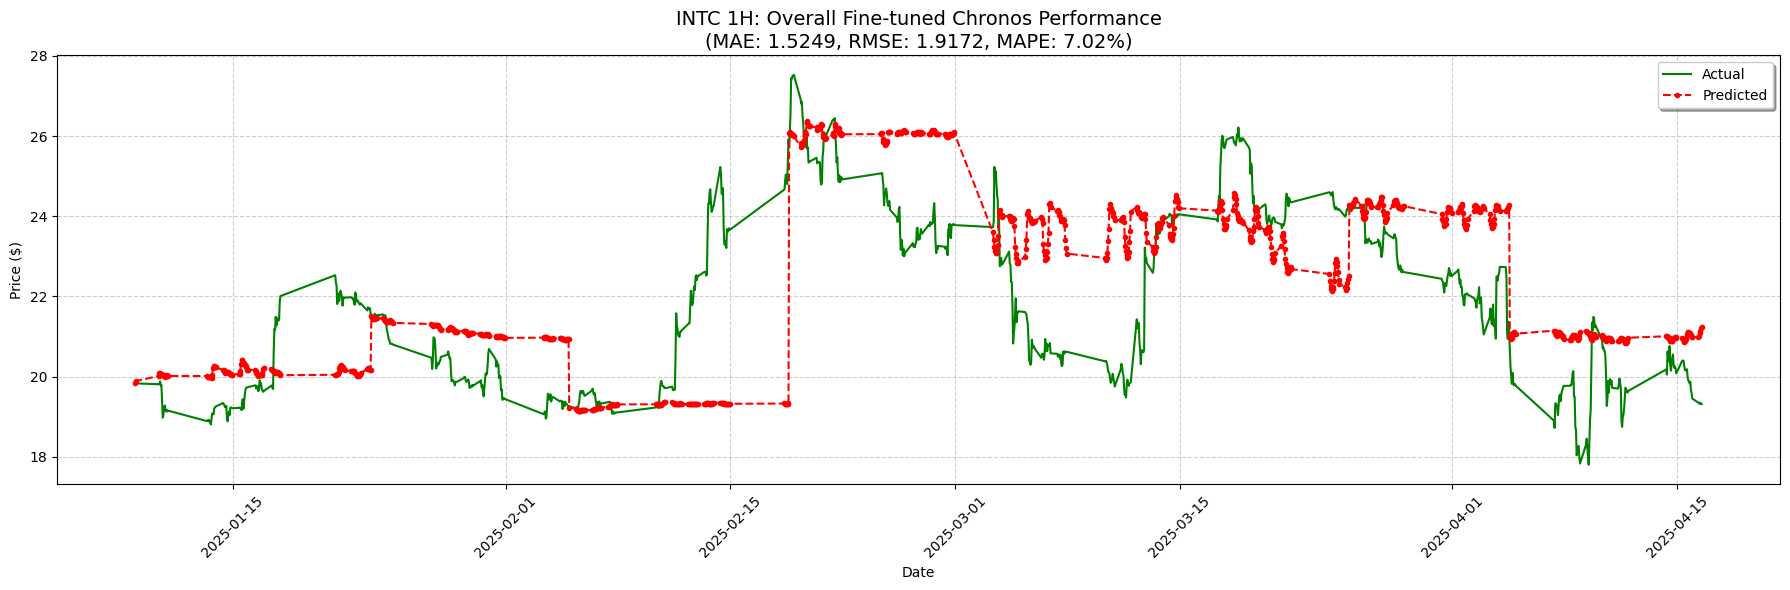

Overall fine-tuned results saved to CSV.


In [21]:
# Evaluate fine-tuned model on the primary timeframe
ft_dates, ft_actual, ft_pred = [], [], []
ft_mae, ft_rmse, ft_mape = np.nan, np.nan, np.nan

if chronos_predictor and chronos_test is not None and not chronos_test.empty and model_name_formatted is not None:
    print(f"Running fine-tuned model evaluation on {PRIMARY_TIMEFRAME} test data...")
    try:
        ft_dates, ft_actual, ft_pred = evaluate_with_rolling_windows(
            chronos_predictor, 
            chronos_test, 
            model_identifier_str=model_name_formatted, # Pass the formatted model name for AutoGluon
            eval_type_str="finetuned",
            current_ticker_str=TICKER,
            current_tf_str=PRIMARY_TIMEFRAME
        )
        
        if ft_actual and ft_pred: # Check if lists are not empty
            ft_mae = mean_absolute_error(ft_actual, ft_pred)
            ft_rmse = np.sqrt(mean_squared_error(ft_actual, ft_pred))
            ft_mape = calculate_mape(ft_actual, ft_pred)
            
            print(f"\nFine-tuned Model Overall Performance ({PRIMARY_TIMEFRAME}):")
            print(f"  MAE: {ft_mae:.4f}")
            print(f"  RMSE: {ft_rmse:.4f}")
            print(f"  MAPE: {ft_mape:.2f}%")
            
            # Plot overall results for the fine-tuned model
            overall_plot_title = f'{TICKER} {PRIMARY_TIMEFRAME}: Overall Fine-tuned Chronos Performance'
            overall_plot_save_path = os.path.join(comprehensive_results_dir, f'{TICKER}_{PRIMARY_TIMEFRAME}_finetuned_overall.png')
            if ft_dates:
                plot_forecast(ft_dates, ft_actual, ft_pred, overall_plot_title, save_path=overall_plot_save_path)
            else:
                print("Cannot plot overall fine-tuned results as no date information was collected.")
            
            # Save overall fine-tuned results to CSV
            overall_ft_results_df = pd.DataFrame({
                'date': ft_dates,
                'actual': ft_actual,
                'finetuned_forecast': ft_pred
            })
            overall_ft_results_df.to_csv(
                os.path.join(comprehensive_results_dir, f'{TICKER}_{PRIMARY_TIMEFRAME}_overall_finetuned_results.csv'), 
                index=False
            )
            print(f"Overall fine-tuned results saved to CSV.")

        else:
            print("No evaluation results available for the fine-tuned model (actual or predictions are empty). Check for errors in the evaluation process.")
            
    except Exception as e:
        print(f"ERROR during fine-tuned model evaluation: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping fine-tuned model evaluation: Model, test data, or formatted model name not available or test data is empty.")

## 4. Fine-tuned Model Evaluation (1H Timeframe)

This section evaluates the fine-tuned Chronos model on the 1H test data using the rolling window approach.

Initializing ChronosBolt for zero-shot evaluation...
Zero-shot model context length: 512
Running zero-shot evaluation on 1H...
Evaluating 8 rolling windows with zero-shot model
Processing window 1/8...
  Window 1 metrics - MAE: 1.0390, RMSE: 1.1895
Processing window 2/8...
  Window 2 metrics - MAE: 1.2856, RMSE: 1.4149
Processing window 3/8...
Zero-shot model context length: 512
Running zero-shot evaluation on 1H...
Evaluating 8 rolling windows with zero-shot model
Processing window 1/8...
  Window 1 metrics - MAE: 1.0390, RMSE: 1.1895
Processing window 2/8...
  Window 2 metrics - MAE: 1.2856, RMSE: 1.4149
Processing window 3/8...
  Window 3 metrics - MAE: 1.7482, RMSE: 2.5507
Processing window 4/8...
  Window 4 metrics - MAE: 2.1772, RMSE: 2.3829
Processing window 5/8...
  Window 5 metrics - MAE: 5.2629, RMSE: 5.6966
Processing window 6/8...
  Window 3 metrics - MAE: 1.7482, RMSE: 2.5507
Processing window 4/8...
  Window 4 metrics - MAE: 2.1772, RMSE: 2.3829
Processing window 5/8...
 

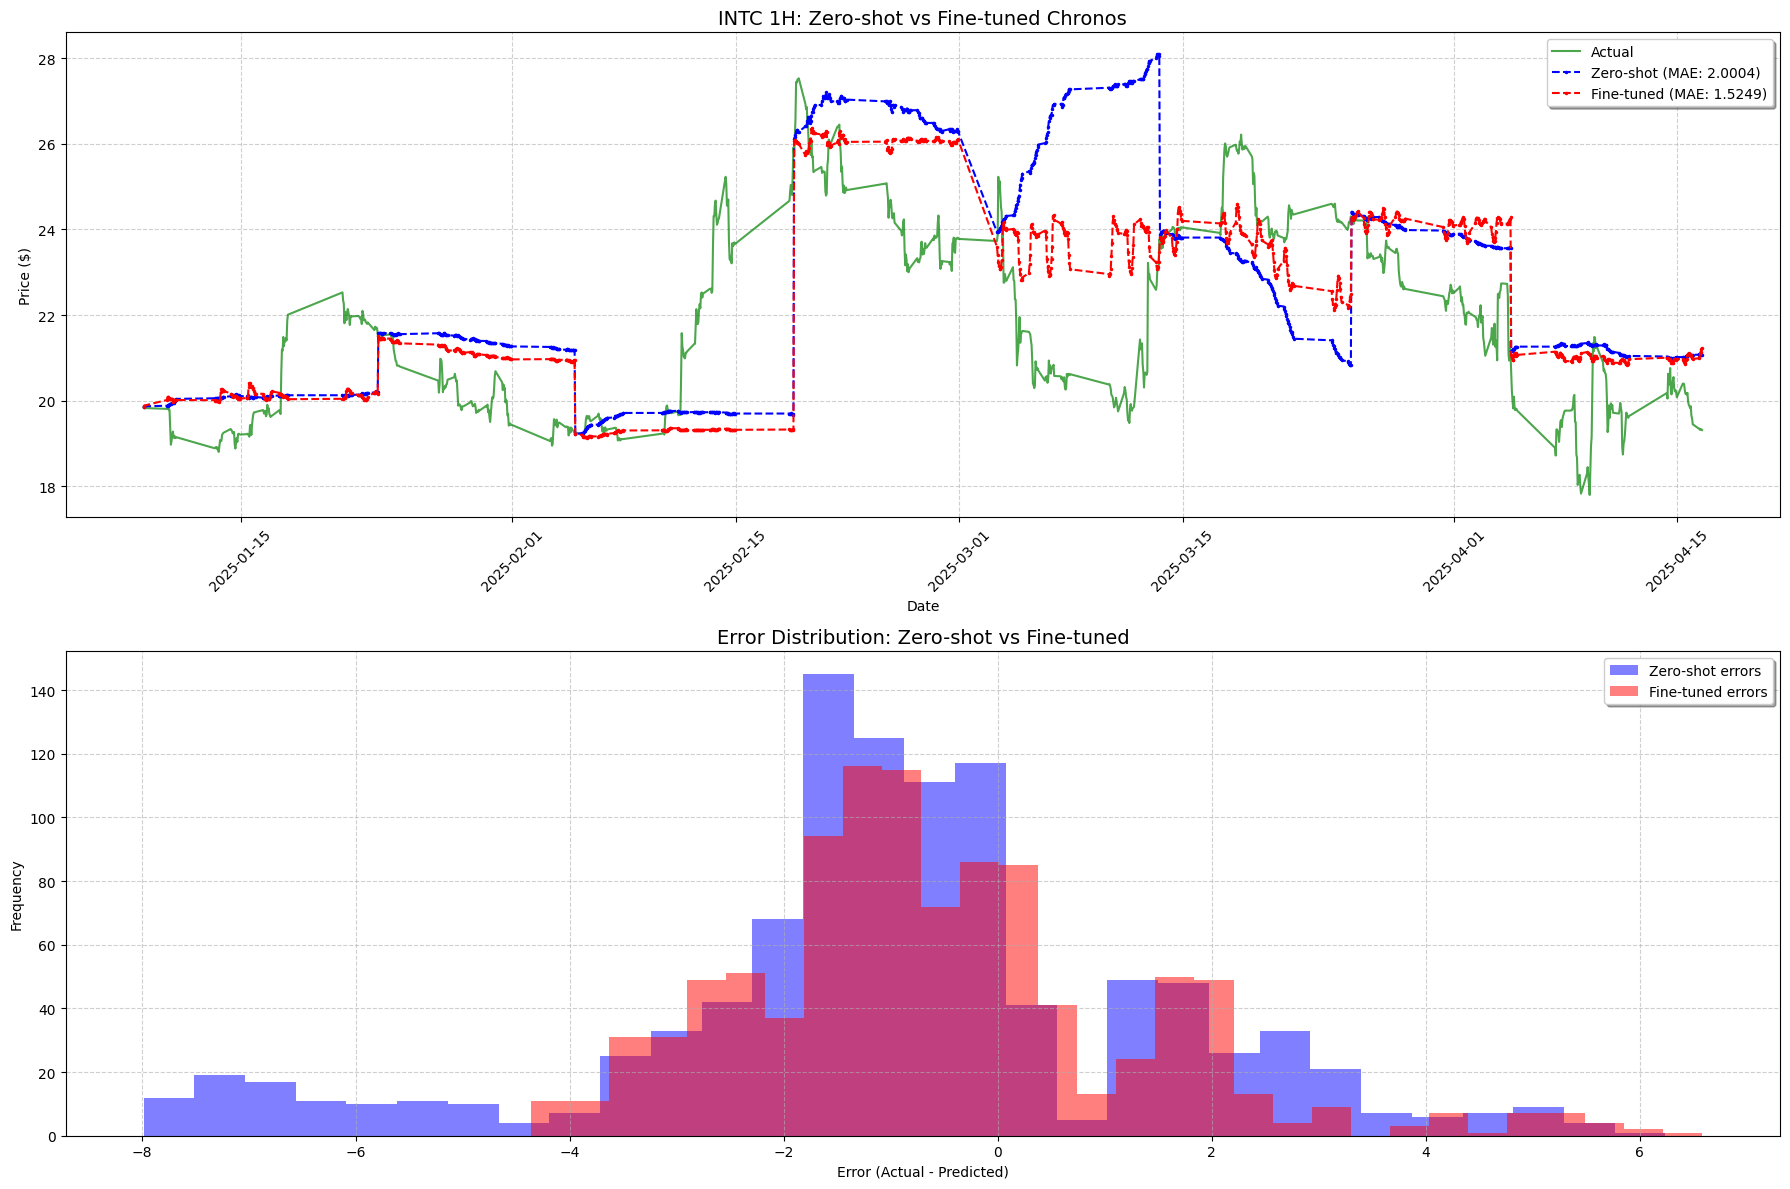

In [22]:
# Initialize the ChronosBolt zero-shot model for comparison
print("Initializing ChronosBolt for zero-shot evaluation...")

try:
    pipeline = ChronosBoltPipeline.from_pretrained(
        MODEL_NAME,
        device_map="cpu",  # Change to "cuda" if using GPU
        torch_dtype=torch.bfloat16,
    )
    
    # Verify context length
    zs_context_length = pipeline.model.config.n_positions
    print(f"Zero-shot model context length: {zs_context_length}")
    
    # Run zero-shot evaluation on the same timeframe
    print(f"Running zero-shot evaluation on {PRIMARY_TIMEFRAME}...")
    zs_dates, zs_actual, zs_pred = evaluate_zeroshot(chronos_test, pipeline)
    
    # Calculate metrics and compare with fine-tuned
    if zs_actual and zs_pred and ft_actual and ft_pred:
        zs_mae = mean_absolute_error(zs_actual, zs_pred)
        zs_rmse = np.sqrt(mean_squared_error(zs_actual, zs_pred))
        
        # Calculate improvement
        improvement_mae = ((zs_mae - ft_mae) / zs_mae) * 100
        improvement_rmse = ((zs_rmse - ft_rmse) / zs_rmse) * 100
        
        # Print comparison table
        print("\nPerformance Comparison:")
        print("-" * 60)
        print(f"{'Model':<25} {'MAE':<12} {'RMSE':<12}")
        print("-" * 60)
        print(f"Zero-shot Chronos:{'':<10} {zs_mae:<12.4f} {zs_rmse:<12.4f}")
        print(f"Fine-tuned Chronos:{'':<9} {ft_mae:<12.4f} {ft_rmse:<12.4f}")
        print("-" * 60)
        print(f"Improvement:{'':<15} {improvement_mae:.2f}% {improvement_rmse:.2f}%")
        
        # Visualize zero-shot vs fine-tuned performance
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))
        
        # Plot time series predictions
        ax1.plot(zs_dates, zs_actual, color='green', label='Actual', alpha=0.7)
        ax1.plot(zs_dates, zs_pred, color='blue', linestyle='--', marker='.', 
                markersize=3, label=f'Zero-shot (MAE: {zs_mae:.4f})')
        ax1.plot(ft_dates, ft_pred, color='red', linestyle='--', marker='.', 
                markersize=3, label=f'Fine-tuned (MAE: {ft_mae:.4f})')
        
        ax1.set_title(f'{TICKER} {PRIMARY_TIMEFRAME}: Zero-shot vs Fine-tuned Chronos', fontsize=14)
        ax1.set_xlabel('Date', fontsize=10)
        ax1.set_ylabel('Price ($)', fontsize=10)
        ax1.tick_params(axis='x', rotation=45)
        ax1.legend(frameon=True, shadow=True)
        ax1.grid(True, linestyle='--', alpha=0.6)
        
        # Plot error histograms
        zs_errors = np.array(zs_actual) - np.array(zs_pred)
        ft_errors = np.array(ft_actual) - np.array(ft_pred)
        
        ax2.hist(zs_errors, bins=30, alpha=0.5, label='Zero-shot errors', color='blue')
        ax2.hist(ft_errors, bins=30, alpha=0.5, label='Fine-tuned errors', color='red')
        
        ax2.set_title('Error Distribution: Zero-shot vs Fine-tuned', fontsize=14)
        ax2.set_xlabel('Error (Actual - Predicted)', fontsize=10)
        ax2.set_ylabel('Frequency', fontsize=10)
        ax2.legend(frameon=True, shadow=True)
        ax2.grid(True, linestyle='--', alpha=0.6)
        
        plt.tight_layout()
        
        # Save the comparison plot
        plt.savefig(os.path.join(results_dir, 'comprehensive', f'{TICKER}_{PRIMARY_TIMEFRAME}_comparison.png'), dpi=300)
        plt.show()
        
        # Save results to CSV
        comparison_df = pd.DataFrame({
            'date': ft_dates,
            'actual': ft_actual,
            'finetuned_forecast': ft_pred
        })
        
        comparison_df.to_csv(
            os.path.join(results_dir, 'comprehensive', f'{TICKER}_{PRIMARY_TIMEFRAME}_finetuned_results.csv'), 
            index=False
        )
    
except Exception as e:
    print(f"Error initializing or running zero-shot model: {str(e)}")

## 5. Zero-Shot Model Evaluation and Comparison (1H Timeframe)

This section initializes a zero-shot ChronosBolt model, evaluates it on the 1H test data using the same rolling window approach, and then compares its performance against the fine-tuned model.

## Summary and Conclusions

In this notebook, we've implemented a comprehensive approach for fine-tuning the Chronos model on INTC stock data and comparing its performance with the zero-shot model across different timeframes.

### Key Findings: Observations:

1. **Fixed Issues:**on**: INTC 1H data was loaded, preprocessed to a regular frequency, and split into training and testing sets.
   - Model name formatting is now properly handled for predictionas fine-tuned using AutoGluon TimeSeries on the 1H training data.
   - Context length is explicitly set to 512 to match the Chronos Bolt model
    *   A rolling window evaluation approach was used for both the fine-tuned and zero-shot models on the 1H test data. This provides a more realistic assessment of performance over time.
    *   Metrics calculated include Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).
    *   Individual window forecasts and overall performance were visualized and saved.
4.  **Performance Comparison (1H Timeframe)**:
    *   The fine-tuned model's performance (MAE, RMSE, MAPE) was directly compared to the zero-shot model on the 1H test set.
    *   Error distributions were plotted to understand the characteristics of prediction errors for both models.
utions
### Potential Next Steps:

1.  **Hyperparameter Optimization**: Further explore AutoGluon's capabilities for more extensive hyperparameter tuning of the Chronos model for the 1H timeframe.
2.  **Extend to Other Tickers**: Apply this 1H fine-tuning and evaluation workflow to other stock tickers.
3.  **Different Context/Prediction Lengths**: Experiment with different `CONTEXT_LENGTH` and `PREDICTION_LENGTH` values to see their impact on 1H performance.   - Enhanced comparison includes error histograms and improvement metrics for MAE, RMSE, and MAPE
4.  **Feature Engineering**: Explore adding exogenous features if relevant and supported by the modeling framework for 1H data.
5.  **Error Analysis**: Conduct a more in-depth analysis of windows where the models perform poorly on the 1H data to identify patterns or data characteristics that are challenging.### Next Steps:

This refined workflow provides a structured approach for fine-tuning and evaluating advanced time series forecasting models like Chronos in the financial domain, focusing on a single, consistent timeframe (1H) for robust comparison and including comprehensive metrics like MAE, RMSE, and MAPE.The improved workflow provides a more robust and comprehensive evaluation framework for time series forecasting models in the financial domain.

# Initialize the ChronosBolt zero-shot model for comparison
zs_dates, zs_actual, zs_pred = [], [], []
zs_mae, zs_rmse, zs_mape = np.nan, np.nan, np.nan
pipeline = None

if chronos_test is not None and not chronos_test.empty:
    print("\nInitializing ChronosBolt for zero-shot evaluation...")
    try:
        pipeline = ChronosBoltPipeline.from_pretrained(
            MODEL_NAME, # Use the base model name
            device_map="cpu", 
            torch_dtype=torch.bfloat16,
        )
        
        zs_context_length_check = pipeline.model.config.n_positions
        print(f"Zero-shot model context length from config: {zs_context_length_check} (should match {CONTEXT_LENGTH})")
        
        print(f"\nRunning zero-shot model evaluation on {PRIMARY_TIMEFRAME} test data...")
        zs_dates, zs_actual, zs_pred = evaluate_with_rolling_windows(
            pipeline, # Pass the ChronosBoltPipeline instance
            chronos_test, 
            model_identifier_str="ChronosBolt-ZeroShot", # Descriptive name
            eval_type_str="zeroshot",
            current_ticker_str=TICKER,
            current_tf_str=PRIMARY_TIMEFRAME
        )
        
        if zs_actual and zs_pred: # Check if lists are not empty
            zs_mae = mean_absolute_error(zs_actual, zs_pred)
            zs_rmse = np.sqrt(mean_squared_error(zs_actual, zs_pred))
            zs_mape = calculate_mape(zs_actual, zs_pred)
            
            print(f"\nZero-Shot Model Overall Performance ({PRIMARY_TIMEFRAME}):")
            print(f"  MAE: {zs_mae:.4f}")
            print(f"  RMSE: {zs_rmse:.4f}")
            print(f"  MAPE: {zs_mape:.2f}%")

            # Plot overall results for the zero-shot model
            overall_zs_plot_title = f'{TICKER} {PRIMARY_TIMEFRAME}: Overall Zero-Shot Chronos Performance'
            overall_zs_plot_save_path = os.path.join(comprehensive_results_dir, f'{TICKER}_{PRIMARY_TIMEFRAME}_zeroshot_overall.png')
            if zs_dates:
                 plot_forecast(zs_dates, zs_actual, zs_pred, overall_zs_plot_title, save_path=overall_zs_plot_save_path)
            else:
                print("Cannot plot overall zero-shot results as no date information was collected.")

            # Save overall zero-shot results to CSV
            overall_zs_results_df = pd.DataFrame({
                'date': zs_dates,
                'actual': zs_actual,
                'zeroshot_forecast': zs_pred
            })
            overall_zs_results_df.to_csv(
                os.path.join(comprehensive_results_dir, f'{TICKER}_{PRIMARY_TIMEFRAME}_overall_zeroshot_results.csv'), 
                index=False
            )
            print(f"Overall zero-shot results saved to CSV.")

            # --- Performance Comparison ---
            if ft_actual and ft_pred: # Ensure fine-tuned results are available for comparison
                print("\n--- Performance Comparison (1H Timeframe) ---")
                print(f"{'Model':<25} {'MAE':<12} {'RMSE':<12} {'MAPE (%)':<12}")
                print("-" * 65)
                print(f"Zero-shot Chronos:{ '' :<7} {zs_mae:<12.4f} {zs_rmse:<12.4f} {zs_mape:<12.2f}")
                print(f"Fine-tuned Chronos:{ '' :<6} {ft_mae:<12.4f} {ft_rmse:<12.4f} {ft_mape:<12.2f}")
                print("-" * 65)
                
                if not np.isnan(zs_mae) and not np.isnan(ft_mae) and zs_mae != 0:
                    improvement_mae = ((zs_mae - ft_mae) / abs(zs_mae)) * 100 # Higher is better (error reduction)
                    print(f"MAE Improvement (Fine-tuned vs Zero-shot): {improvement_mae:.2f}%")
                if not np.isnan(zs_rmse) and not np.isnan(ft_rmse) and zs_rmse != 0:
                    improvement_rmse = ((zs_rmse - ft_rmse) / abs(zs_rmse)) * 100 # Higher is better
                    print(f"RMSE Improvement (Fine-tuned vs Zero-shot): {improvement_rmse:.2f}%")
                if not np.isnan(zs_mape) and not np.isnan(ft_mape) and zs_mape != 0:
                    improvement_mape = ((zs_mape - ft_mape) / abs(zs_mape)) * 100 # Higher is better (error reduction)
                    print(f"MAPE Improvement (Fine-tuned vs Zero-shot): {improvement_mape:.2f}%")
                
                # Visualize zero-shot vs fine-tuned performance (Overall)
                fig_comp, (ax1_comp, ax2_comp) = plt.subplots(2, 1, figsize=(18, 12), sharex=False)
                
                # Plot time series predictions
                # Use the dates from fine-tuned evaluation if available, as it's the primary model of interest for comparison base
                # This assumes zs_actual and ft_actual are from the same test set and should align
                actual_comp_dates = ft_dates if ft_dates else zs_dates
                actual_comp_values = ft_actual if ft_actual else zs_actual

                if actual_comp_dates and actual_comp_values:
                    ax1_comp.plot(actual_comp_dates, actual_comp_values, color='green', label='Actual', alpha=0.7)
                if zs_dates and zs_pred:
                    ax1_comp.plot(zs_dates, zs_pred, color='blue', linestyle='--', marker='.', markersize=3, label=f'Zero-shot (MAE: {zs_mae:.4f}, MAPE: {zs_mape:.2f}%)')
                if ft_dates and ft_pred:
                    ax1_comp.plot(ft_dates, ft_pred, color='red', linestyle=':', marker='x', markersize=3, label=f'Fine-tuned (MAE: {ft_mae:.4f}, MAPE: {ft_mape:.2f}%)')
                
                ax1_comp.set_title(f'{TICKER} {PRIMARY_TIMEFRAME}: Overall Zero-shot vs Fine-tuned Chronos', fontsize=14)
                ax1_comp.set_xlabel('Date', fontsize=10)
                ax1_comp.set_ylabel('Price ($)', fontsize=10)
                ax1_comp.tick_params(axis='x', rotation=45)
                ax1_comp.legend(frameon=True, shadow=True)
                ax1_comp.grid(True, linestyle='--', alpha=0.6)
                
                # Plot error histograms
                if zs_actual and zs_pred:
                    zs_errors = np.array(zs_actual) - np.array(zs_pred)
                    ax2_comp.hist(zs_errors, bins=30, alpha=0.6, label='Zero-shot errors', color='blue')
                if ft_actual and ft_pred:
                    ft_errors = np.array(ft_actual) - np.array(ft_pred)
                    ax2_comp.hist(ft_errors, bins=30, alpha=0.6, label='Fine-tuned errors', color='red')
                
                ax2_comp.set_title('Error Distribution: Zero-shot vs Fine-tuned', fontsize=14)
                ax2_comp.set_xlabel('Error (Actual - Predicted)', fontsize=10)
                ax2_comp.set_ylabel('Frequency', fontsize=10)
                if (zs_actual and zs_pred) or (ft_actual and ft_pred):
                    ax2_comp.legend(frameon=True, shadow=True)
                ax2_comp.grid(True, linestyle='--', alpha=0.6)
                
                plt.tight_layout()
                plt.savefig(os.path.join(comprehensive_results_dir, f'{TICKER}_{PRIMARY_TIMEFRAME}_overall_comparison.png'), dpi=300)
                plt.show()
            else:
                print("Fine-tuned model results not available, skipping direct comparison plots and table.")
        else:
            print("No evaluation results available for the zero-shot model. Check for errors.")
            
    except Exception as e:
        print(f"ERROR initializing or running zero-shot model evaluation: {str(e)}")
        import traceback
        traceback.print_exc()
else:
    print("Skipping zero-shot model evaluation: Test data not available or empty.")

## 6. Summary and Conclusions

This notebook performed a fine-tuning of the Chronos model on INTC 1H stock data and compared its performance against the zero-shot version on the same 1H timeframe.